In [4]:
import torch
from adaptive_control_gym.envs import DroneEnv
from adaptive_control_gym.controllers import PPO
from tqdm import trange

torch.set_grad_enabled(False)

w_per_dim = 64
env_num = w_per_dim**2
search_dim = 2
env = DroneEnv(
    env_num=env_num, gpu_id=0, seed = 1, 
    res_dyn_param_dim=2
)
res_dyn_param = torch.tensor([-1.0, -1.0], device = env.device)
agent = PPO(
    state_dim=env.state_dim, expert_dim=env.expert_dim, 
    adapt_dim=env.adapt_dim, action_dim=env.action_dim, 
    adapt_horizon=env.adapt_horizon, 
    act_expert_mode=1, cri_expert_mode=1,
    compressor_dim=2, search_dim=0,
    env_num=env_num, gpu_id=0)
loaded_agent = torch.load(
    '/home/pcy/rl/policy-adaptation-survey/results/rl/ppo_ood-only-res2-center-50.pt',
    map_location='cuda:0',
)
agent.act.load_state_dict(loaded_agent['actor'].state_dict())
agent.adaptor.load_state_dict(loaded_agent['adaptor'].state_dict())
agent.compressor.load_state_dict(loaded_agent['compressor'].state_dict())

w = torch.linspace(-1, 1, w_per_dim, device=env.device)
ww = torch.stack(torch.meshgrid(w, w), dim=-1).reshape(env_num, 2)
err_mean = torch.zeros(env_num, device=env.device)
for _ in trange(100):
    agent.last_state, agent.last_info = env.reset()
    env.res_dyn_param = torch.ones_like(env.res_dyn_param, device=env.device) * res_dyn_param
    states, actions, logprobs, rewards, undones, infos = agent.explore_env(env, env.max_steps, deterministic=True, use_adaptor=False, predefined_e=ww)
    err_mean += infos['err_x'].mean(dim=0)
err_mean /= 100
err_mean = err_mean.reshape(w_per_dim, w_per_dim).cpu().numpy()

100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


In [6]:
import numpy as np
compressed_value = agent.compressor(res_dyn_param).detach().cpu().numpy()
compressed_idx = (compressed_value / (2/w_per_dim)+w_per_dim/2).astype(np.int)
compressed_value = err_mean[compressed_idx[1], compressed_idx[0]]

/tmp/ipykernel_496926/587149530.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  compressed_idx = (compressed_value / (2/w_per_dim)+w_per_dim/2).astype(np.int)


Text(0.5, 1.0, 'Error Mean along 2D Search Space, 100 runs, tested on [-1,-1]')

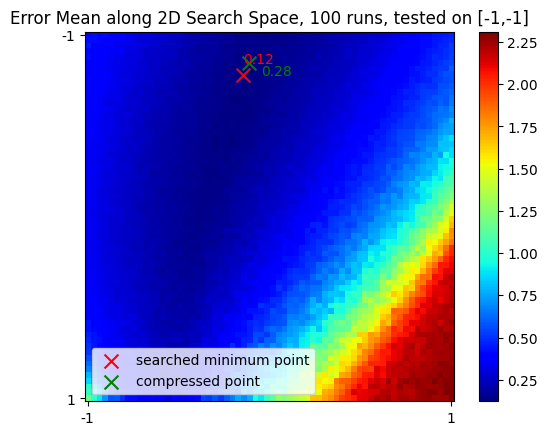

In [7]:
# plot err_mean
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(err_mean, cmap='jet')
plt.colorbar()
# rescale x, y axis
plt.xticks([0, w_per_dim-1], [-1, 1])
plt.yticks([0, w_per_dim-1], [-1, 1])
# show the point with min value
min_idx = np.unravel_index(np.argmin(err_mean, axis=None), err_mean.shape)
min_value = err_mean[min_idx]
plt.scatter(min_idx[1], min_idx[0], marker='x', color='red', s=100, label='searched minimum point')
plt.text(min_idx[1], min_idx[0]-2, f'{min_value:.2f}', color='red')
# show the compressed value
plt.scatter(compressed_idx[1], compressed_idx[0], marker='x', color='green', s=100, label='compressed point')
plt.text(compressed_idx[1]+2, compressed_idx[0]+2, f'{compressed_value:.2f}', color='green')
plt.legend()
plt.title('Error Mean along 2D Search Space, 100 runs, tested on [-1,-1]')